In [30]:
import numpy as np
import pickle

In [31]:
from pathlib import Path
from abc import ABC, abstractmethod

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from cc_hardware.utils.manager import Manager
from cc_hardware.utils.file_handlers import PklReader
from cc_hardware.utils import register_cli, run_cli
from cc_hardware.utils import get_logger

from cc_hardware.algos.datasets import HistogramDataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [32]:
class HistogramDataset(Dataset):
    def __init__(self, pkl_path: Path = None, predict_magnitude: bool = False, rolling_window=5, merge: bool = False):
        if pkl_path is None:
            self.data = []
            self.inputs = []
            self.targets = []
            return

        self.data = PklReader.load_all(pkl_path)
        inputs = dict(
            histogram=[],
            position=[],
        )
        # print(type(self.data))
        for d in self.data:
            # print(type(d))
            # print(d.keys())
            # print(d)
            if "has_masks" in d and not d["has_masks"]:
                d["position"] = [0, 0, 0]
                print("mask continue")
                continue
            if "histogram" not in d or "position" not in d:
                print("hist continue")
                continue
            inputs["histogram"].append(torch.tensor(d["histogram"]))
            
            pos = d["position"]
            # print(f"position: {pos}")
            inputs["position"].append(torch.tensor((pos["x"], pos["y"])))
            # print(f"inputs: {inputs}")
            # raise Exception("exit")
        # print(inputs['position'])
        # print(f"original targets shape: {torch.stack(inputs['position']).shape}")
        
        if len(inputs["histogram"][0].shape) == 2:
            # single capture per location
            # reading input as list of location samples: (pixels, bins)
            # reading targets as list of location samples: ((x, y) position)
            self.raw_inputs = torch.stack(inputs["histogram"]).float()
            num_samples = self.raw_inputs.shape[0]
            width = np.sqrt(self.raw_inputs.shape[1]).astype(int)
            height = width
            bins = self.raw_inputs.shape[2]
            self.raw_inputs = torch.reshape(self.raw_inputs, (num_samples, width, height, bins))
            self.raw_targets = torch.stack(inputs["position"]).float()
        elif len(inputs["histogram"][0].shape) == 3:
            # multiple captures per location:
            # reading input as list of location samples: (captures per location, pixels, bins)
            # reading targets as list of location samples: ((x, y) position)
            self.raw_inputs = torch.stack(inputs["histogram"]).float()  # (locations, captures, pixels, bins)
            samples_per_location = inputs["histogram"][0].shape[0]
            # print(f"samples per location: {samples_per_location}")
            # print(f"raw shape: {self.raw_inputs.shape}")
            if rolling_window is not None:
                sliding_mean = np.array(
                    [self.raw_inputs[:, j - rolling_window + 1: j + 1, :, :].mean(axis=1)
                        for j in range(rolling_window - 1, samples_per_location)
                    ]).swapaxes(0, 1)
                # print(f"sliding mean shape: {sliding_mean.shape}")
                self.raw_inputs = torch.tensor(sliding_mean)
            samples_per_location = self.raw_inputs.shape[1]
            # print(f"samples_per_location: {samples_per_location}")
            # print(f"shape: {self.raw_inputs.shape}")
            self.raw_inputs = torch.reshape(self.raw_inputs, 
                (self.raw_inputs.shape[0] * self.raw_inputs.shape[1], self.raw_inputs.shape[2], self.raw_inputs.shape[3]))
            # self.raw_inputs = torch.concat(inputs["histogram"], dim=0).float()  # (all captures, pixels, bins)
            num_samples = self.raw_inputs.shape[0]
            width = np.sqrt(self.raw_inputs.shape[1]).astype(int)
            height = width
            bins = self.raw_inputs.shape[2]
            self.raw_inputs = torch.reshape(self.raw_inputs, (num_samples, width, height, bins))
            self.raw_targets = torch.stack(inputs["position"], dim=0).float()  # (location samples, (x, y) position)
            self.raw_targets = torch.repeat_interleave(self.raw_targets, samples_per_location, dim=0)

        # raw_inputs: (all captures, width, height, bins)
        # raw_targets: (all captures, (x, y) position)

        self.START_BIN = 0
        self.END_BIN = bins
        self.inputs = self.raw_inputs
        self.targets = self.raw_targets

        if predict_magnitude:
            self.targets = torch.linalg.norm(self.targets, dim=1, keepdim=True)

        if merge:
            self.inputs = self.inputs.sum(dim=(1), keepdim=True)

    def set_start_bin(self, start_bin: int):
        self.START_BIN = start_bin
        self.inputs = self.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]

    def set_end_bin(self, end_bin: int):
        self.END_BIN = end_bin
        self.inputs = self.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]

    def get_raw_bin_num(self):
        return self.raw_inputs.shape[3]

    def get_bin_num(self):
        return self.inputs.shape[3]
    
    def augment(self, factor: int):
        std = self.inputs.std(dim=0)
        self.inputs = self.inputs.repeat_interleave(factor, dim=0)
        self.inputs += torch.normal(torch.zeros_like(self.inputs), std)
        self.targets = self.targets.repeat_interleave(factor, dim=0)

    def get_mean_capture(self):
        return self.inputs.mean(dim=0)
    
    def set_zero(self, zero: torch.Tensor):
        # sets the empty capture of the dataset
        self.inputs = self.inputs - zero

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
    def __add__(self, other):
        combined_dataset = HistogramDataset()
        combined_dataset.raw_inputs = torch.cat((self.raw_inputs, other.raw_inputs), dim=0)
        combined_dataset.raw_targets = torch.cat((self.raw_targets, other.raw_targets), dim=0)
        combined_dataset.START_BIN = self.START_BIN
        combined_dataset.END_BIN = self.END_BIN
        combined_dataset.inputs = combined_dataset.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]
        combined_dataset.targets = combined_dataset.raw_targets
        return combined_dataset


In [33]:
pkl_path = "../../datasets/robotics/localization/demo_arrow/capture_retro_1.pkl"
dataset_1 = HistogramDataset(
    pkl_path,
    rolling_window=5
)
# pkl_path = "../../datasets/robotics/localization/10x10_samples/capture_4.pkl"
# dataset_1 = dataset_1 + HistogramDataset(
#     pkl_path,
# )

In [34]:
dataset_1.raw_inputs.shape

torch.Size([9600, 8, 8, 16])

In [35]:
dataset = dataset_1

In [36]:
dataset.inputs.shape

torch.Size([9600, 8, 8, 16])

In [37]:
dataset.targets.shape

torch.Size([9600, 2])

In [38]:
dataset.inputs.shape

torch.Size([9600, 8, 8, 16])

In [39]:
dataset.targets.shape

torch.Size([9600, 2])

In [40]:
dataset.augment(10)

In [41]:
print(f'input shape: {dataset.inputs.shape}')
print(f'target shape: {dataset.targets.shape}')

input shape: torch.Size([96000, 8, 8, 16])
target shape: torch.Size([96000, 2])


In [19]:
# Define the sizes for training, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(1))

batch_size = 32

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch_x, batch_y in train_loader:
    print(f'batch_x shape: {batch_x.shape}')
    print(f'batch_y shape: {batch_y.shape}')
    break

batch_x shape: torch.Size([32, 8, 8, 16])
batch_y shape: torch.Size([32, 2])


In [21]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [22]:
NUM_BINS = 16
WIDTH = 8
HEIGHT = 8

# NUM_BINS = 32
# WIDTH = 4
# HEIGHT = 4

In [72]:
class LocationCNN(nn.Module):
    def __init__(self):
        super(LocationCNN, self).__init__()
        # self.conv1 = nn.Conv2d(in_channels=(end_bin - start_bin), out_channels=16, kernel_size=3, padding=1)
        # self.batchnorm1 = nn.BatchNorm2d(16)
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        # self.batchnorm2 = nn.BatchNorm2d(64)

        out_channels = 4
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        self.batchnorm3d = nn.BatchNorm3d(out_channels)

        self.fc1 = nn.Linear(out_channels * NUM_BINS * HEIGHT * WIDTH, 128)

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)  # 2 output dimensions (x, y)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # # print(f'x shape at start: {x.shape}')
        # x = self.relu(self.conv1(x))
        # # print(f'x shape after conv1: {x.shape}')
        # x = self.batchnorm1(x)
        # # x = self.pool(x)
        # # print(f'x shape after pool1: {x.shape}')
        # x = self.relu(self.conv2(x))
        # # print(f'x shape after conv2: {x.shape}')
        # x = self.batchnorm2(x)

        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)

        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [73]:
class DeepLocation(nn.Module):
    def __init__(self):
        super(DeepLocation, self).__init__()

        # in: (n, HEIGHT, WIDTH, 42 or 16)
        self.conv_channels = 4
        self.conv_channels2 = 8
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=self.conv_channels, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        # (n, 4, HEIGHT, WIDTH, 42 or 16)
        self.batchnorm3d = nn.BatchNorm3d(self.conv_channels)
        self.batchnorm3d2 = nn.BatchNorm3d(self.conv_channels2)
        # reshape to (n, 4, HEIGHT x WIDTH, 42)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 4, HEIGHT, WIDTH, 21)
        self.conv3d2 = nn.Conv3d(in_channels=self.conv_channels, out_channels=self.conv_channels2, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        # (n, 8, HEIGHT, WIDTH, 21)
        # reshape to (n, 8, HEIGHT x WIDTH, 21)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=3, padding=0)
        # (n, 8, HEIGHT, WIDTH, 7)

        self.fc1 = nn.Linear(self.conv_channels2 * HEIGHT * WIDTH * 7, 128)
        # self.fc1 = nn.Linear(self.conv_channels * NUM_BINS * HEIGHT * WIDTH / 2 / 2 / 2, 128)

        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)  # 2 output dimensions (x, y)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * HEIGHT * WIDTH, NUM_BINS))
        x = self.pool1(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, HEIGHT, WIDTH, -1))
        x = self.relu(self.conv3d2(x))
        x = self.batchnorm3d2(x)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2 * HEIGHT * WIDTH, -1))
        x = self.pool2(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2, HEIGHT, WIDTH, -1))

        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [21]:
class DeepLocation8(nn.Module):
    def __init__(self):
        super(DeepLocation8, self).__init__()

        # in: (n, HEIGHT, WIDTH, 16)
        self.conv_channels = 4
        self.conv_channels2 = 8
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=self.conv_channels, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        # (n, 4, HEIGHT, WIDTH, 16)
        self.batchnorm3d = nn.BatchNorm3d(self.conv_channels)
        self.batchnorm3d2 = nn.BatchNorm3d(self.conv_channels2)
        # reshape to (n, 4, HEIGHT x WIDTH, 16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 4, HEIGHT, WIDTH, 8)
        self.conv3d2 = nn.Conv3d(in_channels=self.conv_channels, out_channels=self.conv_channels2, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        # (n, 8, HEIGHT, WIDTH, 8)
        # reshape to (n, 8, HEIGHT x WIDTH, 8)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 8, HEIGHT, WIDTH, 4)

        self.fc1 = nn.Linear(self.conv_channels2 * HEIGHT * WIDTH * 4, 128)
        # self.fc1 = nn.Linear(self.conv_channels * NUM_BINS * HEIGHT * WIDTH / 2 / 2 / 2, 128)

        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)  # 2 output dimensions (x, y)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * HEIGHT * WIDTH, NUM_BINS))
        x = self.pool1(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, HEIGHT, WIDTH, -1))
        x = self.relu(self.conv3d2(x))
        x = self.batchnorm3d2(x)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2 * HEIGHT * WIDTH, -1))
        x = self.pool2(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2, HEIGHT, WIDTH, -1))

        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [31]:
class DeepLocation8v2(nn.Module):
    def __init__(self):
        super(DeepLocation8v2, self).__init__()

        # in: (n, HEIGHT, WIDTH, 16)
        self.conv_channels = 4
        self.conv_channels2 = 8
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=self.conv_channels, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        # (n, 4, HEIGHT, WIDTH, 16)
        self.batchnorm3d = nn.BatchNorm3d(self.conv_channels)
        self.batchnorm3d2 = nn.BatchNorm3d(self.conv_channels2)
        # reshape to (n, 4, HEIGHT x WIDTH, 16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 4, HEIGHT, WIDTH, 8)
        self.conv3d2 = nn.Conv3d(in_channels=self.conv_channels, out_channels=self.conv_channels2, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        # (n, 8, HEIGHT, WIDTH, 8)
        # reshape to (n, 8, HEIGHT x WIDTH, 8)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 8, HEIGHT, WIDTH, 4)
        self.conv3d3 = nn.Conv3d(in_channels=self.conv_channels2, out_channels=self.conv_channels2, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        # (n, 8, HEIGHT, WIDTH, 4)

        self.fc1 = nn.Linear(self.conv_channels2 * HEIGHT * WIDTH * 4, 128)
        # self.fc1 = nn.Linear(self.conv_channels * NUM_BINS * HEIGHT * WIDTH / 2 / 2 / 2, 128)

        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)  # 2 output dimensions (x, y)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * HEIGHT * WIDTH, NUM_BINS))
        x = self.pool1(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, HEIGHT, WIDTH, -1))
        x = self.relu(self.conv3d2(x))
        x = self.batchnorm3d2(x)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2 * HEIGHT * WIDTH, -1))
        x = self.pool2(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2, HEIGHT, WIDTH, -1))
        x = self.relu(self.conv3d3(x))

        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [32]:
class DeepLocation8Light(nn.Module):
    def __init__(self):
        super(DeepLocation8Light, self).__init__()

        # in: (n, HEIGHT, WIDTH, 16)
        self.conv_channels = 4
        self.conv_channels2 = 8
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=self.conv_channels, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        # (n, 4, HEIGHT, WIDTH, 16)
        self.batchnorm3d = nn.BatchNorm3d(self.conv_channels)
        self.batchnorm3d2 = nn.BatchNorm3d(self.conv_channels2)
        # reshape to (n, 4, HEIGHT x WIDTH, 16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 4, HEIGHT, WIDTH, 8)
        self.pool_flat = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # (n, 4, HEIGHT / 2, WIDTH / 2, 8)
        self.conv3d2 = nn.Conv3d(in_channels=self.conv_channels, out_channels=self.conv_channels2, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        # (n, 8, HEIGHT / 2, WIDTH / 2, 8)
        # reshape to (n, 8, HEIGHT / 2 x WIDTH / 2, 8)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 8, HEIGHT / 2, WIDTH / 2, 4)

        self.fc1 = nn.Linear(self.conv_channels2 * HEIGHT * WIDTH, 128)
        # self.fc1 = nn.Linear(self.conv_channels * NUM_BINS * HEIGHT * WIDTH / 2 / 2 / 2, 128)

        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)  # 2 output dimensions (x, y)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # in: (n, HEIGHT, WIDTH, 16)
        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)
        # (n, 4, HEIGHT, WIDTH, 16)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * HEIGHT * WIDTH, NUM_BINS))
        # reshape to (n, 4 x HEIGHT x WIDTH, 16)
        x = self.pool1(x)
        # (n, 4 x HEIGHT x WIDTH, 8)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, HEIGHT, WIDTH, -1))
        # (n, 4, HEIGHT, WIDTH, 8)

        x = torch.transpose(x, 2, 4)
        # (n, 4, 8, WIDTH, HEIGHT)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * 8, WIDTH, HEIGHT))
        # reshape to (n, 4 x 8, WIDTH, HEIGHT)
        x = self.pool_flat(x)
        # reshape to (n, 4 x 8, WIDTH / 2, HEIGHT / 2)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, 8, 4, 4))
        # reshape to (n, 4, 8, WIDTH / 2, HEIGHT / 2)
        x = torch.transpose(x, 2, 4)
        # (n, 4, HEIGHT / 2, WIDTH / 2, 8)

        # x = torch.reshape(x, (x.shape[0], self.conv_channels, HEIGHT, WIDTH, -1))
        # (n, 4, HEIGHT / 2, WIDTH / 2, 8)
        x = self.relu(self.conv3d2(x))
        x = self.batchnorm3d2(x)
        # (n, 8, HEIGHT / 2, WIDTH / 2, 8)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2 * HEIGHT * WIDTH, -1))
        # reshape to (n, 8 x HEIGHT / 2 x WIDTH / 2, 8)
        x = self.pool2(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2, HEIGHT, WIDTH, -1))
        # (n, 8, HEIGHT / 2, WIDTH / 2, 4)
        
        # print(x.shape)

        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [321]:
class DeepLocation2(nn.Module):
    def __init__(self):
        super(DeepLocation2, self).__init__()

        # in: (n, 4, 4, 42)
        self.conv_channels = 4
        self.conv_channels2 = 8
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=self.conv_channels, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        # (n, 4, 4, 4, 42)
        self.batchnorm3d = nn.BatchNorm3d(self.conv_channels)
        self.batchnorm3d2 = nn.BatchNorm3d(self.conv_channels2)
        # reshape to (n, 4, 4 x 4, 42)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 4, 4, 4, 21)
        self.conv3d2 = nn.Conv3d(in_channels=self.conv_channels, out_channels=self.conv_channels2, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        # (n, 8, 4, 4, 21)
        # reshape to (n, 8, 4 x 4, 7)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=3, padding=0)
        # (n, 8, 4, 4, 7)
        self.conv3d3 = nn.Conv3d(in_channels=self.conv_channels2, out_channels=self.conv_channels2, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        # (n, 8, 4, 4, 7)

        self.fc1 = nn.Linear(self.conv_channels2 * HEIGHT * WIDTH * 7, 128)
        # self.fc1 = nn.Linear(self.conv_channels * NUM_BINS * HEIGHT * WIDTH / 2 / 2 / 2, 128)

        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)  # 2 output dimensions (x, y)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * 4 * 4, NUM_BINS))
        x = self.pool1(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, 4, 4, -1))
        x = self.relu(self.conv3d2(x))
        x = self.batchnorm3d2(x)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2 * 4 * 4, -1))
        x = self.pool2(x)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2, 4, 4, -1))
        # print(x.shape)
        x = self.relu(self.conv3d3(x))

        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [414]:
class DeepLocation4Light(nn.Module):
    def __init__(self):
        super(DeepLocation4Light, self).__init__()

        # in: (n, HEIGHT, WIDTH, 32)
        self.conv_channels = 4
        self.conv_channels2 = 8
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=self.conv_channels, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        # (n, 4, HEIGHT, WIDTH, 32)
        self.batchnorm3d = nn.BatchNorm3d(self.conv_channels)
        self.batchnorm3d2 = nn.BatchNorm3d(self.conv_channels2)
        # reshape to (n, 4, HEIGHT x WIDTH, 32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 4, HEIGHT, WIDTH, 16)
        self.pool_flat = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # (n, 4, HEIGHT / 2, WIDTH / 2, 16)
        self.conv3d2 = nn.Conv3d(in_channels=self.conv_channels, out_channels=self.conv_channels2, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        # (n, 8, HEIGHT / 2, WIDTH / 2, 16)
        # reshape to (n, 8, HEIGHT / 2 x WIDTH / 2, 16)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # (n, 8, HEIGHT / 2, WIDTH / 2, 8)

        self.fc1 = nn.Linear(self.conv_channels2 * HEIGHT * WIDTH * 2, 128)

        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)  # 2 output dimensions (x, y)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # in: (n, HEIGHT, WIDTH, 32)
        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)
        # (n, 4, HEIGHT, WIDTH, 32)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * HEIGHT * WIDTH, NUM_BINS))
        # reshape to (n, 4 x HEIGHT x WIDTH, 32)
        x = self.pool1(x)
        # (n, 4 x HEIGHT x WIDTH, 16)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, HEIGHT, WIDTH, -1))
        # (n, 4, HEIGHT, WIDTH, 16)

        x = torch.transpose(x, 2, 4)
        # (n, 4, 16, WIDTH, HEIGHT)
        x = torch.reshape(x, (x.shape[0], self.conv_channels * 16, WIDTH, HEIGHT))
        # reshape to (n, 4 x 16, WIDTH, HEIGHT)
        x = self.pool_flat(x)
        # reshape to (n, 4 x 16, WIDTH / 2, HEIGHT / 2)
        x = torch.reshape(x, (x.shape[0], self.conv_channels, 16, 2, 2))
        # reshape to (n, 4, 16, WIDTH / 2, HEIGHT / 2)
        x = torch.transpose(x, 2, 4)
        # (n, 4, HEIGHT / 2, WIDTH / 2, 16)

        x = self.relu(self.conv3d2(x))
        x = self.batchnorm3d2(x)
        # (n, 8, HEIGHT / 2, WIDTH / 2, 16)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2 * HEIGHT * WIDTH, -1))
        # reshape to (n, 8 x HEIGHT /2  x WIDTH /2, 16)
        x = self.pool2(x)
        # print(x.shape)
        # (n, 8 x HEIGHT /2  x WIDTH /2, 8)
        x = torch.reshape(x, (x.shape[0], self.conv_channels2, HEIGHT, WIDTH, -1))
        # (n, 8, HEIGHT / 2, WIDTH / 2, 8)
        
        # print(x.shape)

        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [22]:
# Instantiate the model
model = DeepLocation8().to(device)
print(model)

DeepLocation8(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 7), stride=(1, 1, 1), padding=(1, 1, 3))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3d2): Conv3d(4, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1), padding=(1, 1, 2))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [23]:
# Calculate total number of parameters
total_params = sum(param.numel() for param in model.parameters())
print(f"Total number of parameters: {total_params}")

# Calculate total number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of parameters: 264514
Total number of trainable parameters: 264514


In [24]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv3d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(initialize_weights)

DeepLocation8(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 7), stride=(1, 1, 1), padding=(1, 1, 3))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3d2): Conv3d(4, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1), padding=(1, 1, 2))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [25]:
# Use MSELoss for euclidean distance to true location
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=10.0)

In [26]:
def train(dataloader, model, loss_fn, optimizer, clipping=False, debug=False):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        if len(X) < batch_size:
            continue

        X, y = X.to(device), y.to(device)
        # print(f'X shape: {X.shape}, y shape: {y.shape}')
        # Compute prediction error
        pred = model(X)
        # print(f'pred shape: {pred.shape}, y shape: {y.shape}')
        loss = loss_fn(pred, y)
        # print(f'loss: {loss.item()}')
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        if clipping:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed
        
        if debug:
            # Inspect gradients for each layer
            for name, param in model.named_parameters():
                if param.grad is not None:  # Only check if gradient is computed
                    print(f"Layer: {name} | Gradient mean: {param.grad.abs().mean().item()} | Gradient max: {param.grad.abs().max().item()}")
                else:
                    print(f"Layer: {name} has no gradient.")

        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= len(dataloader)
    return train_loss

In [27]:
def test(dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    # test_loss, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # y = y.unsqueeze_(1)
            # print(X.shape)
            # print(y.shape)
            test_loss += loss_fn(pred, y).item()
            # final_pred = torch.round(torch.clamp(pred, min=0, max=1))
            # final_pred = torch.round(torch.sigmoid(pred))
            
            # print(final_pred.shape)
            # print("true")
            # print(y)
            # print("pred")
            # print(final_pred)
            # print("diff")
            # print(final_pred - y)
            # exact_match = torch.all(final_pred == torch.round(y), dim=1)
            # correct += torch.sum(exact_match).item()
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

In [28]:
def train_early_stopping(train_loader, val_loader, model, loss_fn, optimizer, 
    epochs=50, early_stopping=True, patience=5, threshold=0.15, clipping=False, debug=False):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, clipping=clipping, debug=debug)
        val_loss = test(val_loader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                if val_loss / best_val_loss > 1 + threshold:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {t+1}")
                        break
        # print(f'patience_counter: {patience_counter}')

        best_model = model.__class__().to(device)
        best_model.load_state_dict(best_model_state)
    return best_model, train_losses, val_losses

Epoch 1
-------------------------------
loss: 536.262024  [   32/48000]
loss: 27.098471  [ 3232/48000]
loss: 36.673786  [ 6432/48000]
loss: 29.187811  [ 9632/48000]
loss: 31.017727  [12832/48000]
loss: 24.668493  [16032/48000]
loss: 15.378814  [19232/48000]
loss: 24.885490  [22432/48000]
loss: 22.495411  [25632/48000]
loss: 17.373211  [28832/48000]
loss: 16.889500  [32032/48000]
loss: 22.160856  [35232/48000]
loss: 16.332251  [38432/48000]
loss: 16.871567  [41632/48000]
loss: 19.148268  [44832/48000]
Test Error: 
 Avg loss: 21.277752 

Epoch 2
-------------------------------
loss: 30.202023  [   32/48000]
loss: 18.084728  [ 3232/48000]
loss: 24.990395  [ 6432/48000]
loss: 26.495132  [ 9632/48000]
loss: 24.524754  [12832/48000]
loss: 22.449631  [16032/48000]
loss: 25.522778  [19232/48000]
loss: 27.963928  [22432/48000]
loss: 13.331367  [25632/48000]
loss: 13.939528  [28832/48000]
loss: 17.548454  [32032/48000]
loss: 35.703030  [35232/48000]
loss: 14.564808  [38432/48000]
loss: 30.865002

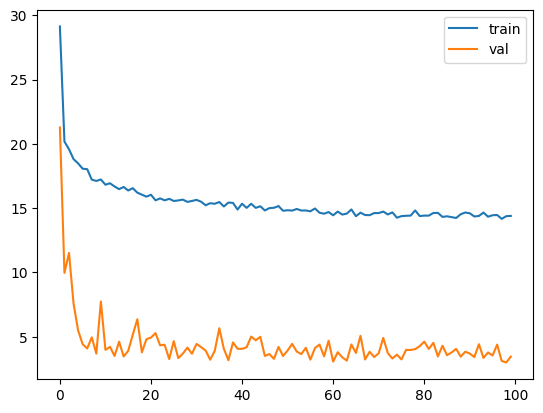

In [29]:
best_model, train_losses, val_losses = train_early_stopping(
    train_loader, val_loader, model, loss_fn, optimizer, epochs=100, early_stopping=True,
    threshold=0.4, patience=10,
    clipping=True)

# plot training and validation losses
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


model = best_model

In [31]:
model_save_path = '../../models/robotics/demo/demo_model_1.mdl'

In [32]:
torch.save(model.state_dict(), model_save_path)

In [33]:
model = DeepLocation8().to(device)
model.load_state_dict(torch.load(model_save_path))

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_39721/3376311315.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

<All keys matched successfully>

In [34]:
# Out of sample test
model.eval()
# test(test_loader, model, loss_fn)
test(test_loader, model, loss_fn)

Test Error: 
 Avg loss: 3.443261 



3.443260994911194

In [35]:
for i in range(20):
    # Get a single example from the test dataset
    example_data, example_label = test_dataset[i]
    example_label = example_label.to(device)

    # Move the example data to the appropriate device
    example_data = example_data.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        example_data = example_data.to(device)
        output = model(example_data).squeeze()

    print(f'Prediction: {output}, Actual label: {example_label}, Distance: {torch.norm(output - example_label):.4f}')

Prediction: tensor([17.7640, 36.5456], device='mps:0'), Actual label: tensor([19.4444, 37.3333], device='mps:0'), Distance: 1.8559
Prediction: tensor([18.9485, 30.4962], device='mps:0'), Actual label: tensor([19.4444, 32.6667], device='mps:0'), Distance: 2.2264
Prediction: tensor([34.2352,  9.1067], device='mps:0'), Actual label: tensor([35.0000,  9.3333], device='mps:0'), Distance: 0.7977
Prediction: tensor([28.7053, 18.1529], device='mps:0'), Actual label: tensor([31.1111, 18.6667], device='mps:0'), Distance: 2.4600
Prediction: tensor([20.2127, 14.4444], device='mps:0'), Actual label: tensor([23.3333, 14.0000], device='mps:0'), Distance: 3.1522
Prediction: tensor([ 9.0680, 19.7447], device='mps:0'), Actual label: tensor([ 7.7778, 18.6667], device='mps:0'), Distance: 1.6813
Prediction: tensor([ 7.4840, 10.1587], device='mps:0'), Actual label: tensor([7.7778, 9.3333], device='mps:0'), Distance: 0.8761
Prediction: tensor([1.6323e-02, 4.4839e+01], device='mps:0'), Actual label: tensor([ 

## External testing set

In [36]:
pkl_path = "../../datasets/robotics/localization/demo_arrow/capture_retro_mini_1.pkl"
dataset_test = HistogramDataset(
    pkl_path, rolling_window=5
)

In [93]:
dataset_test.set_start_bin(6)
dataset_test.set_end_bin(38)

In [37]:
dataset_test.inputs.shape

torch.Size([600, 8, 8, 16])

In [38]:
external_test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [39]:
external_test_loader.dataset.inputs.shape

torch.Size([600, 8, 8, 16])

In [40]:
test(external_test_loader, model, loss_fn)

Test Error: 
 Avg loss: 3.682401 



3.6824012492832385

In [41]:
def x_loss(y_pred, y_true):
    return torch.mean(torch.pow(y_pred[:, 0] - y_true[:, 0], 2))

def y_loss(y_pred, y_true):
    return torch.mean(torch.pow(y_pred[:, 1] - y_true[:, 1], 2))

def mse_loss(y_pred, y_true):
    return torch.mean(torch.pow(y_pred - y_true, 2))

In [42]:
test(external_test_loader, model, x_loss)

Test Error: 
 Avg loss: 5.405213 



5.405213465816097

In [43]:
test(external_test_loader, model, y_loss)

Test Error: 
 Avg loss: 1.959589 



1.9595888162914075

In [44]:
test(external_test_loader, model, mse_loss)

Test Error: 
 Avg loss: 3.682401 



3.682401173993161

In [45]:
for i in range(20):
    # Get a single example from the test dataset
    example_data, example_label = test_dataset[i]
    example_label = example_label.to(device)

    # Move the example data to the appropriate device
    example_data = example_data.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        example_data = example_data.to(device)
        output = model(example_data).squeeze()

    print(f'Prediction: {output.cpu()}, Actual label: {example_label.cpu()}, Distance: {torch.norm(output - example_label):.4f}')

Prediction: tensor([17.7640, 36.5456]), Actual label: tensor([19.4444, 37.3333]), Distance: 1.8559
Prediction: tensor([18.9485, 30.4962]), Actual label: tensor([19.4444, 32.6667]), Distance: 2.2264
Prediction: tensor([34.2352,  9.1067]), Actual label: tensor([35.0000,  9.3333]), Distance: 0.7977
Prediction: tensor([28.7053, 18.1529]), Actual label: tensor([31.1111, 18.6667]), Distance: 2.4600
Prediction: tensor([20.2127, 14.4444]), Actual label: tensor([23.3333, 14.0000]), Distance: 3.1522
Prediction: tensor([ 9.0680, 19.7447]), Actual label: tensor([ 7.7778, 18.6667]), Distance: 1.6813
Prediction: tensor([ 7.4840, 10.1587]), Actual label: tensor([7.7778, 9.3333]), Distance: 0.8761
Prediction: tensor([1.6323e-02, 4.4839e+01]), Actual label: tensor([ 0., 42.]), Distance: 2.8389
Prediction: tensor([17.0154, 44.2996]), Actual label: tensor([15.5556, 42.0000]), Distance: 2.7239
Prediction: tensor([ 8.1354, 25.1166]), Actual label: tensor([ 7.7778, 23.3333]), Distance: 1.8188
Prediction: te